# Random Digits Exercice

## Description:
This is an exercise in hypothesis testing, specifically determining if a series of digits [0,9] is random or not. In order to determine this, one has to design and applied statistical tests, from which the degree of consistency of being random can be calculated.

## Your task:
Using tests of your choice/design, determine which of the eight data sets are consistent with being random, and which aren't. One is based on the digits you entered in the course questionaire, while the others range from poor/quasi random to truly random. See if you can determine your (human) dataset.

##  Author: 
- Troels Petersen ([email](mailto:petersen@nbi.dk))

##  Date:
15th of December 2020

---

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [3]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

---
## Define your functions here:


In [4]:
# Fill 1d histograms:
def create_1d_hist(ax, values, bins, x_range, title):
    ax.hist(values, bins, x_range, histtype='step', density=False, lw=2)         
    ax.set(xlim=x_range, title=title)
    hist_data = np.histogram(values, bins, x_range)
    return hist_data

In [5]:
# Calculate the ChiSquare value for comparison of histogram with constant.
# This is not a fit, as there is no free parameters: We know the number of events and bins!
def get_chi2_ndf( hist, const):
    data = hist[0]
    const_unnormed = const * data.sum()
    chi2 = np.sum( (data - const_unnormed)**2 / data )
    ndof = data.size
    return chi2, ndof

---
## Import random numbers from text file:

In [6]:
# Define list of input files:
infiles = ["data_RandomDigits2020_F.txt" ]

In [7]:
# List containing all numbers:
numbers = []

In [8]:
# Loop over input files open them in read mode
for ifile in infiles : 
    with open( ifile, "r" ) as current_file : 
        # Extract current file info : Loop through each line in the file, loop through each character
        # in the line, demand character is not empty ("") and convert the result to an integer
        # Finally add result to the numbers list
        numbers += [int(char) for line in current_file for char in line.strip() if char is not ""]

In [9]:
numbers = np.array(numbers)
print(numbers, len(numbers))

[1 3 2 ... 7 3 1] 6523


---
## Define your tests:

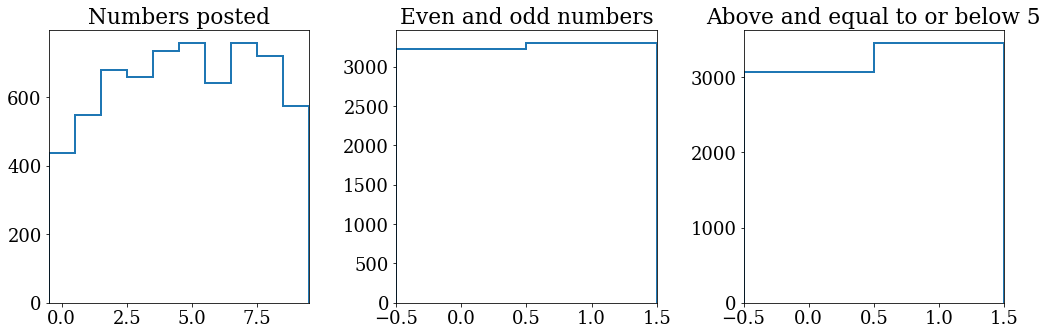

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
ax_number, ax_odd_even, ax_high_low = ax.flatten()

# Fill 1d histograms and plot them:
hist_numbers  = create_1d_hist(ax_number,   numbers,     10, (-0.5, 9.5), 'Numbers posted')                # Plot all digits
hist_odd_even = create_1d_hist(ax_odd_even, numbers % 2,  2, (-0.5, 1.5), 'Even and odd numbers')          # Is number even or odd
hist_high_low = create_1d_hist(ax_high_low, numbers // 5, 2, (-0.5, 1.5), 'Above and equal to or below 5') # Is number >= or < 5
fig.tight_layout()

---
## Calculate the $\chi^{2}$ given a constant value (Constant is not a free parameter here)

In [11]:
chi2_ndf_number_hist   = get_chi2_ndf( hist_numbers,  1.0 / 10)
chi2_ndf_odd_even_hist = get_chi2_ndf( hist_odd_even, 1.0 / 2 )
chi2_ndf_high_low_hist = get_chi2_ndf( hist_high_low, 1.0 / 2 )

In [12]:
# Write your result: 
print("Compatability that distributions stem from random numbers : ")
print("Raw digits: Prob(Chi2={:6.2f}, Ndof={:2d}) = {:10.8f}".format(chi2_ndf_number_hist[0], chi2_ndf_number_hist[1], 
                                                             stats.chi2.sf(chi2_ndf_number_hist[0], chi2_ndf_number_hist[1])))
print("Odd/Even:   Prob(Chi2={:6.2f}, Ndof={:2d}) = {:10.8f}".format(chi2_ndf_odd_even_hist[0], chi2_ndf_odd_even_hist[1], 
                                                             stats.chi2.sf(chi2_ndf_odd_even_hist[0], chi2_ndf_odd_even_hist[1])))
print("High/Low:   Prob(Chi2={:6.2f}, Ndof={:2d}) = {:10.8f}".format(chi2_ndf_high_low_hist[0], chi2_ndf_high_low_hist[1], 
                                                             stats.chi2.sf(chi2_ndf_high_low_hist[0], chi2_ndf_high_low_hist[1])))

Compatability that distributions stem from random numbers : 
Raw digits: Prob(Chi2=182.50, Ndof=10) = 0.00000000
Odd/Even:   Prob(Chi2=  1.11, Ndof= 2) = 0.57470199
High/Low:   Prob(Chi2= 24.01, Ndof= 2) = 0.00000612


## Compare sequence frequency with Poisson hypothesis (for sequence length 3):

The probability of any specific sequence of three digits has probability $1/1000$ for random numbers. With $N$ digits (roughly 5000 here), each sequence should be represented $lambda = N/1000$ times, and as $p$ of a specific sequence is small and the number of sequences $N$ is large, the distribution of sequence frequency should follow a Poisson distribution. This is tested below.

In [13]:
# Poisson:
# -------------
def func_Poisson(x, N, lamb) :
    if (x > -0.5) :
        return N * stats.poisson.pmf(x, lamb)
    else : 
        return 0.0
    
func_Poisson_vec = np.vectorize(func_Poisson)

### Count how many of each sequency:

Thus, for sequences of length 3 there are 1000 posibilities, which are then counted in a histogram spanning 1000 bins. This works for all seqence lengths!

In [14]:
seq = []
for i in range(-2, len(numbers)-2) : 
    seq.append(100*numbers[i] + 10*numbers[i+1] + numbers[i+2])
seq = np.array(seq)

# Put it into a histogram, which spans all possible outcomes:
poisson_counts, _ = np.histogram(seq, 1001, range=(-0.5, 1000.5))

### Plotting the distribution (in the relevant range):

Note the binning, which is (again) made to match integers in a range (this little trick/choice is very useful):

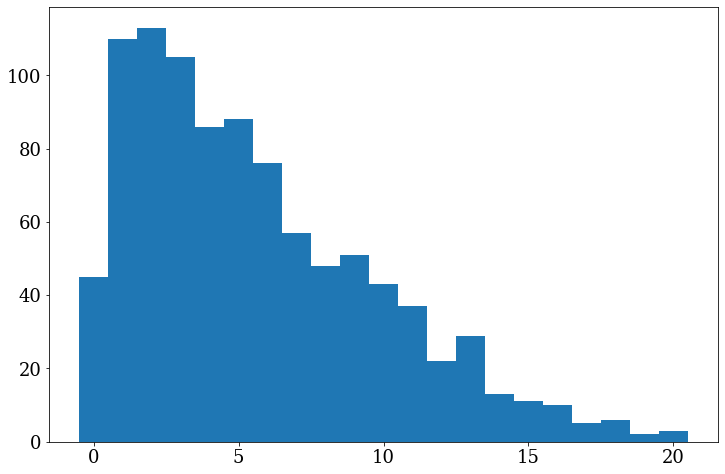

In [15]:
Nbins = 21
xmin, xmax = -0.5, 20.5

fig3, ax3 = plt.subplots(figsize=(12,8))
hist_poisson3 = ax3.hist(poisson_counts, Nbins, range=(xmin, xmax))

counts, x_edges, _ = hist_poisson3
x_centers = 0.5*(x_edges[1:] + x_edges[:-1])

In [16]:
x = x_centers[counts>0]
y = counts[counts>0]
sy = np.sqrt(y)

chi2_object = Chi2Regression(func_Poisson, x, y, sy)
minuit = Minuit(chi2_object, pedantic=False, N=1000, lamb=poisson_counts.mean())
minuit.migrad()     # Launch the fit

chi2_val = minuit.fval
N_DOF = len(y) - len(minuit.args)
chi2_prob = stats.chi2.sf(chi2_val, N_DOF)
print("The Poisson fit yields a probability of {:8.6f}".format(chi2_prob))

The Poisson fit yields a probability of 0.000000


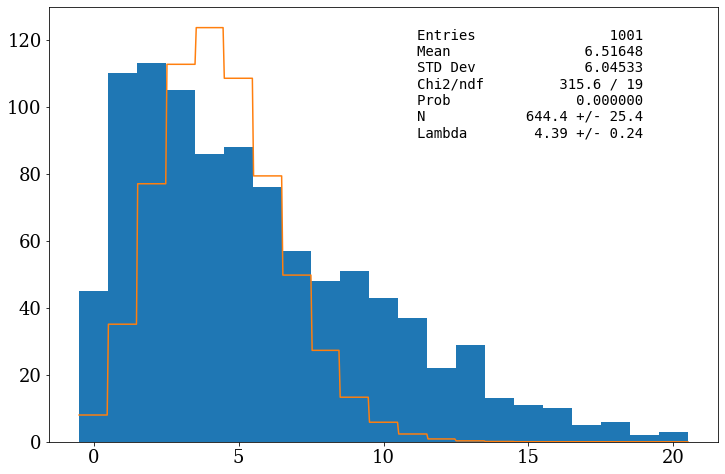

In [17]:
d = {'Entries'  : "{:d}".format(len(poisson_counts)),
     'Mean'     : "{:.5f}".format(poisson_counts.mean()),
     'STD Dev'  : "{:.5f}".format(poisson_counts.std(ddof=1)),
     'Chi2/ndf' : "{:.1f} / {:2d}".format(chi2_val, N_DOF),
     'Prob'     : "{:.6f}".format(chi2_prob),
     'N'        : "{:.1f} +/- {:.1f}".format(minuit.values['N'], minuit.errors['N']),
     'Lambda'   : "{:.2f} +/- {:.2f}".format(minuit.values['lamb'], minuit.errors['lamb'])
    }

ax3.text(0.55, 0.95, nice_string_output(d),
    family='monospace',
    transform=ax3.transAxes, fontsize=14,
    verticalalignment='top');

binwidth = (xmax-xmin) / Nbins 
xaxis = np.linspace(xmin, xmax, 500)
yaxis = binwidth*func_Poisson_vec(np.floor(xaxis+0.5), *minuit.args)
ax3.plot(xaxis, yaxis)
fig3

Questions:
---
 1. Discuss with your peers, what truly random numbers should satisfy, and how these criteria can be tested.
    Based on this and discussion in class, write up such tests, and run all the datasets through to see,
    if some do not seem to be truly random.

 2. Not all the non-human data sets are random, but they are never the less more regular (in some sense), than the       humanly generated one. See if you can determine, which one is "your" (humanly generated) data.

The different datasets were distributed as follows (thus "F" was the humanly produced from the questionaire):
 - data_RandomDigits2020_100WithShift → B
 - data_RandomDigits2020_7thCopiedFrom5before.txt → E
 - data_RandomDigits2020_TrulyRandom.txt → G
 - data_RandomDigits2020_Students.txt → F
 - data_RandomDigits2020_DigitsOfPi.txt → D
 - data_RandomDigits2020_IceCubedata.txt → A
 - data_RandomDigits2020_FourGaussians.txt → C